# Comparison of greenness scores
Felix Zaussinger | 29.07.2021

## Core Analysis Goal(s)
1. Check agreement of the old (clearly wrong!), updated and reference greenness scores

## Key Insight(s)
1. The updated and reference scores are very similar. On average, the updated ones
are slightly higher than the reference scores from the Vona 2018 publication appendix.
However, I can cover around 30 more occupations using the updated scores, so I will
stick with those.

In [73]:
import os
import sys
import logging
from pathlib import Path

import numpy as np
import scipy as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("ticks")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Define directory structure

In [74]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_interim = os.path.join(project_dir, "data", "interim")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "reports", "figures")

Code ...

In [75]:
g1 = pd.read_excel(
    os.path.join(data_raw, "onet", "Onet_GreenTask_AppA.xlsx"),
    sheet_name="Occupations"
)

g2 = pd.read_excel(
    os.path.join(data_raw, "onet", "vona_2018_table_a1.xlsx"),
    sheet_name="Greenness"
)

In [76]:
g_all = pd.merge(
    g1,
    g2,
    on="onet_code",
    how="left"
)

g_all

,onet_code,title_x,occupation_type,n_new_green_tasks,n_existing_green_tasks,n_non_green_tasks,greenness_vona_2018,greenness_vona_2018_v2,title_y,greenness,total_spec_tasks,green_spec_tasks
0,11-1011.03,Chief Sustainability Officers,New Green N&E,18,0,0,1.00,1.00,Chief Sustainability Officers,1.00,18.0,18.0
1,11-1021.00,General and Operations Managers,Green Enhanced Skills,1,1,15,0.13,0.12,General and Operations Managers,0.06,18.0,1.0
2,11-2011.01,Green Marketers,New Green N&E,16,0,0,1.00,1.00,NaN,NaN,NaN,NaN
3,11-2021.00,Marketing Managers,Green Enhanced Skills,4,0,16,0.25,0.20,Marketing Managers,0.20,20.0,4.0
4,11-3051.02,Geothermal Production Managers,New Green N&E,17,0,0,1.00,1.00,Geothermal Production Managers,1.00,17.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...
133,51-9199.01,Recycling and Reclamation Workers,New Green N&E,18,0,0,1.00,1.00,Recycling and Reclamation Workers,1.00,18.0,18.0
134,53-1021.01,Recycling Coordinators,New Green N&E,23,0,0,1.00,1.00,NaN,NaN,NaN,NaN
135,53-3032.00,"Truck Drivers, Heavy and Tractor-Trailer",Green Enhanced Skills,3,0,28,0.11,0.10,Heavy and Tractor-Trailer Truck Drivers,0.09,33.0,3.0
136,53-6051.07,"Transportation Vehicle, Equipment and Systems ...",Green Enhanced Skills,8,1,12,0.75,0.43,"Transportation Vehicle, Equipment and Systems ...",0.41,22.0,9.0


In [104]:
df_metadata = pd.read_csv(
    os.path.join(data_interim, "ESCO_ONET_METADATA_gbn.csv"),
    index_col=0
)

In [144]:
# correct greenness values for ambiguous gbn cases
df_metadata[(df_metadata.is_green == False) & (df_metadata.greenness_vona_2018_v2 > 0)]["greenness_vona_2018_v2"] = 0
df_metadata[(df_metadata.is_green == False) & (df_metadata.greenness_vona_2018_v2 > 0)]

10      0.05
164     0.05
490     0.05
594     0.05
629     0.05
665     0.05
726     0.05
1011    0.05
1113    0.05
1184    0.05
1241    0.05
1262    0.05
1354    0.05
1502    0.05
1548    0.05
1718    0.05
1791    0.05
1846    0.05
1847    0.05
2020    0.05
2148    0.05
2182    0.05
2247    0.05
2294    0.05
2379    0.05
2543    0.05
2631    0.05
2791    0.05
2797    0.05
2914    0.05
Name: greenness_vona_2018_v2, dtype: float64

In [78]:
skills = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "skills_en.csv"))

### Analysis 1
- create subset of occupations with greenness = 1
- count the number of times a skill is required (essential/optional) across those occupations

,id,concept_uri,preferred_label,isco_level_4,onet_code,onet_occupation,isco_level_1,isco_level_2,isco_level_3,occupation_type,n_new_green_tasks,n_existing_green_tasks,n_non_green_tasks,greenness_vona_2018,greenness_vona_2018_v2,total_paid_hours,annual_earnings,employment_share,employment_count,job_zone,education_level,related_work_experience,on_the_job_training,skill_level_ilo,new_jobs_absorbing_ilo_2030_es,new_jobs_net_ilo_2030_es,jobs_lost_net_ilo_2030_es,jobs_lost_reallocated_ilo_2030_es,net_change_ilo_2030_es,new_jobs_absorbing_ilo_2030_ce,new_jobs_net_ilo_2030_ce,jobs_lost_net_ilo_2030_ce,jobs_lost_reallocated_ilo_2030_ce,net_change_ilo_2030_ce,is_brown,is_green,is_neutral
180,181,http://data.europa.eu/esco/occupation/0e99c929...,renewable energy engineer,2149,17-2199.03,energy engineers,2,21,214,Existing Green N&E,1.0,20.0,0.0,1.0,1.0,38.50,35911.87,NaN,NaN,4.0,6.50,7.46,4.05,H,500000.0,2.63e+05,-253000.0,-500000.0,1.00e+04,1.38e+06,1.27e+06,-3.97e+05,-1.38e+06,8.77e+05,False,True,False
214,215,http://data.europa.eu/esco/occupation/114e1eff...,renewable energy consultant,2433,13-1199.05,sustainability specialists,2,24,243,New Green N&E,14.0,0.0,0.0,1.0,1.0,37.21,41242.61,6.48e-04,20834.0,4.0,6.57,6.86,3.64,H,218000.0,1.47e+05,-75000.0,-218000.0,7.20e+04,8.23e+05,8.37e+05,-5.30e+04,-8.23e+05,7.84e+05,False,True,False
238,239,http://data.europa.eu/esco/occupation/1313aeea...,corporate social responsibility manager,1219,11-1011.03,chief sustainability officers,1,12,121,New Green N&E,18.0,0.0,0.0,1.0,1.0,35.50,34973.80,1.72e-03,55197.0,5.0,6.92,8.88,4.69,H,132000.0,1.28e+05,-54000.0,-132000.0,7.40e+04,5.96e+05,7.97e+05,-3.20e+04,-5.96e+05,7.65e+05,False,True,False
339,340,http://data.europa.eu/esco/occupation/1b99cad3...,wind energy engineer,2149,17-2199.03,energy engineers,2,21,214,Existing Green N&E,1.0,20.0,0.0,1.0,1.0,38.50,35911.87,NaN,NaN,4.0,6.50,7.46,4.05,H,500000.0,2.63e+05,-253000.0,-500000.0,1.00e+04,1.38e+06,1.27e+06,-3.97e+05,-1.38e+06,8.77e+05,False,True,False
388,390,http://data.europa.eu/esco/occupation/1ff61522...,energy systems engineer,2149,17-2199.03,energy engineers,2,21,214,Existing Green N&E,1.0,20.0,0.0,1.0,1.0,38.50,35911.87,NaN,NaN,4.0,6.50,7.46,4.05,H,500000.0,2.63e+05,-253000.0,-500000.0,1.00e+04,1.38e+06,1.27e+06,-3.97e+05,-1.38e+06,8.77e+05,False,True,False
419,421,http://data.europa.eu/esco/occupation/22987b58...,green ICT consultant,2511,13-1199.05,sustainability specialists,2,25,251,New Green N&E,14.0,0.0,0.0,1.0,1.0,36.82,41914.33,7.91e-04,25432.0,4.0,6.57,6.86,3.64,H,65000.0,4.90e+04,-40000.0,-65000.0,9.00e+03,1.87e+05,2.96e+05,-3.10e+04,-1.87e+05,2.65e+05,False,True,False
428,430,http://data.europa.eu/esco/occupation/23a61ff1...,energy conservation officer,3112,47-4099.03,weatherization installers and technicians,3,31,311,New Green N&E,18.0,0.0,0.0,1.0,1.0,37.26,31261.07,2.11e-04,6784.0,2.0,2.83,4.93,4.60,H,748000.0,5.28e+05,-206000.0,-748000.0,3.22e+05,3.04e+06,1.22e+06,-9.65e+05,-3.04e+06,2.60e+05,False,True,False
445,447,http://data.europa.eu/esco/occupation/2480f8b0...,refuse vehicle driver,8332,53-7081.00,refuse and recyclable material collectors,8,83,833,Green Enhanced Skills,1.0,15.0,0.0,1.0,1.0,46.75,28971.55,1.39e-03,44706.0,2.0,1.80,3.86,2.77,M,329000.0,8.10e+05,-33000.0,-329000.0,7.77e+05,2.90e+06,7.53e+05,-2.61e+06,-2.90e+06,-1.86e+06,False,True,False
487,490,http://data.europa.eu/esco/occupation/28742973...,water quality analyst,2133,19-4091.00,environmental science and protection technicia...,2,21,213,Green Enhanced Skills,3.0,23.0,0.0,1.0,1.0,36.41,32143.65,2.71e-04,8720.0,4.0,6.27,6.43,5.10,H,500000.0,2.63e+05,-253000.0,-500000.0,1.00e+04,1.38e+06,1.27e+06,-3.97e+05,-1.38e+06,8.77e+05,False,True,False
606,609,http://data.europa.eu/esco/occupation/32548f7e...,environmental mining engineer,2143,17-2081.00,environmental engineers,2,21,214,Green Enhanced Skills,3.0,25.0,0.0,1.0,1.0,40.80,34463.53,NaN,NaN,5.0,7.15,5.55,4.70,H,500000.0,2.63e+05,-253000.0,-500000.0,1.00e+04,1.38e+

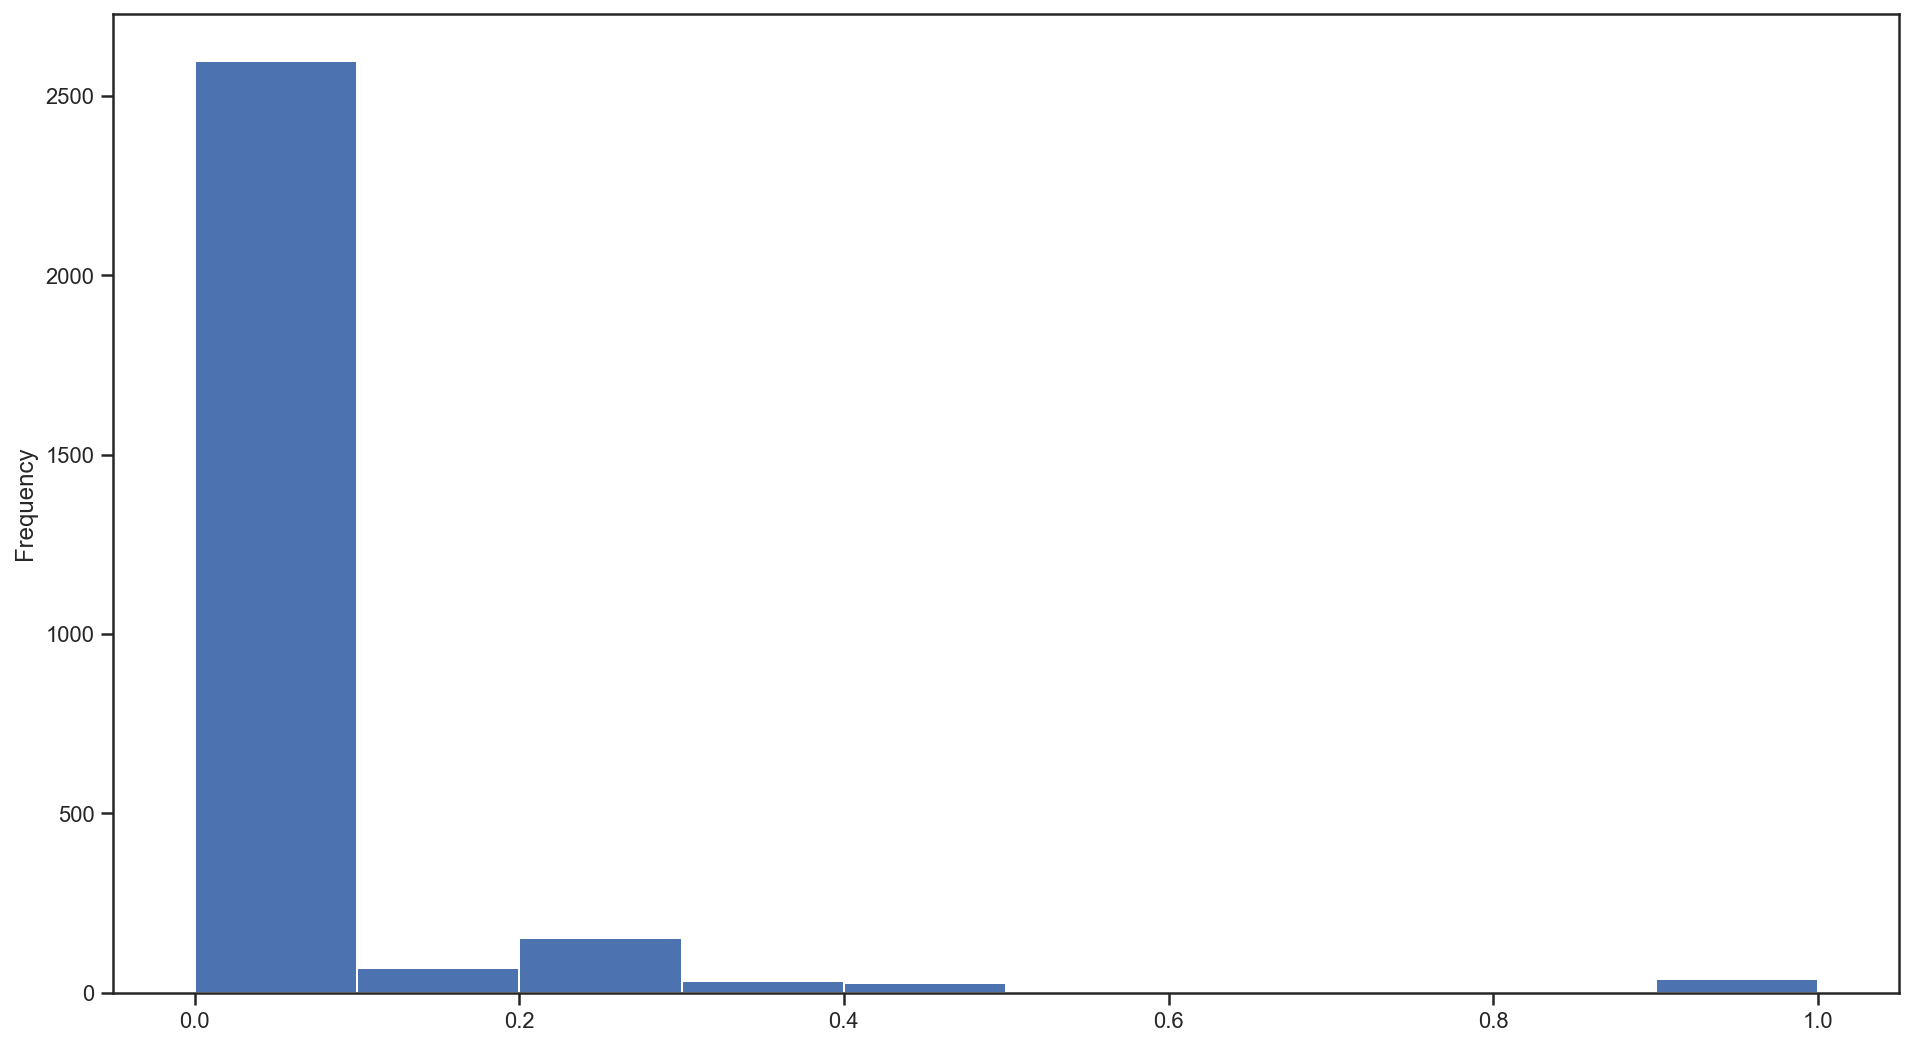

In [110]:
df_metadata.sort_values("greenness_vona_2018_v2", ascending=False).head(35)
df_metadata.greenness_vona_2018_v2.plot.hist()
df_metadata.greenness_vona_2018_v2.quantile(np.arange(0,1.1,0.1))

df_subset = df_metadata[df_metadata.greenness_vona_2018_v2 == 1]
df_subset

In [106]:
df_metadata.greenness_vona_2018_v2.describe()

count    2921.00
mean        0.04
std         0.14
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         1.00
Name: greenness_vona_2018_v2, dtype: float64

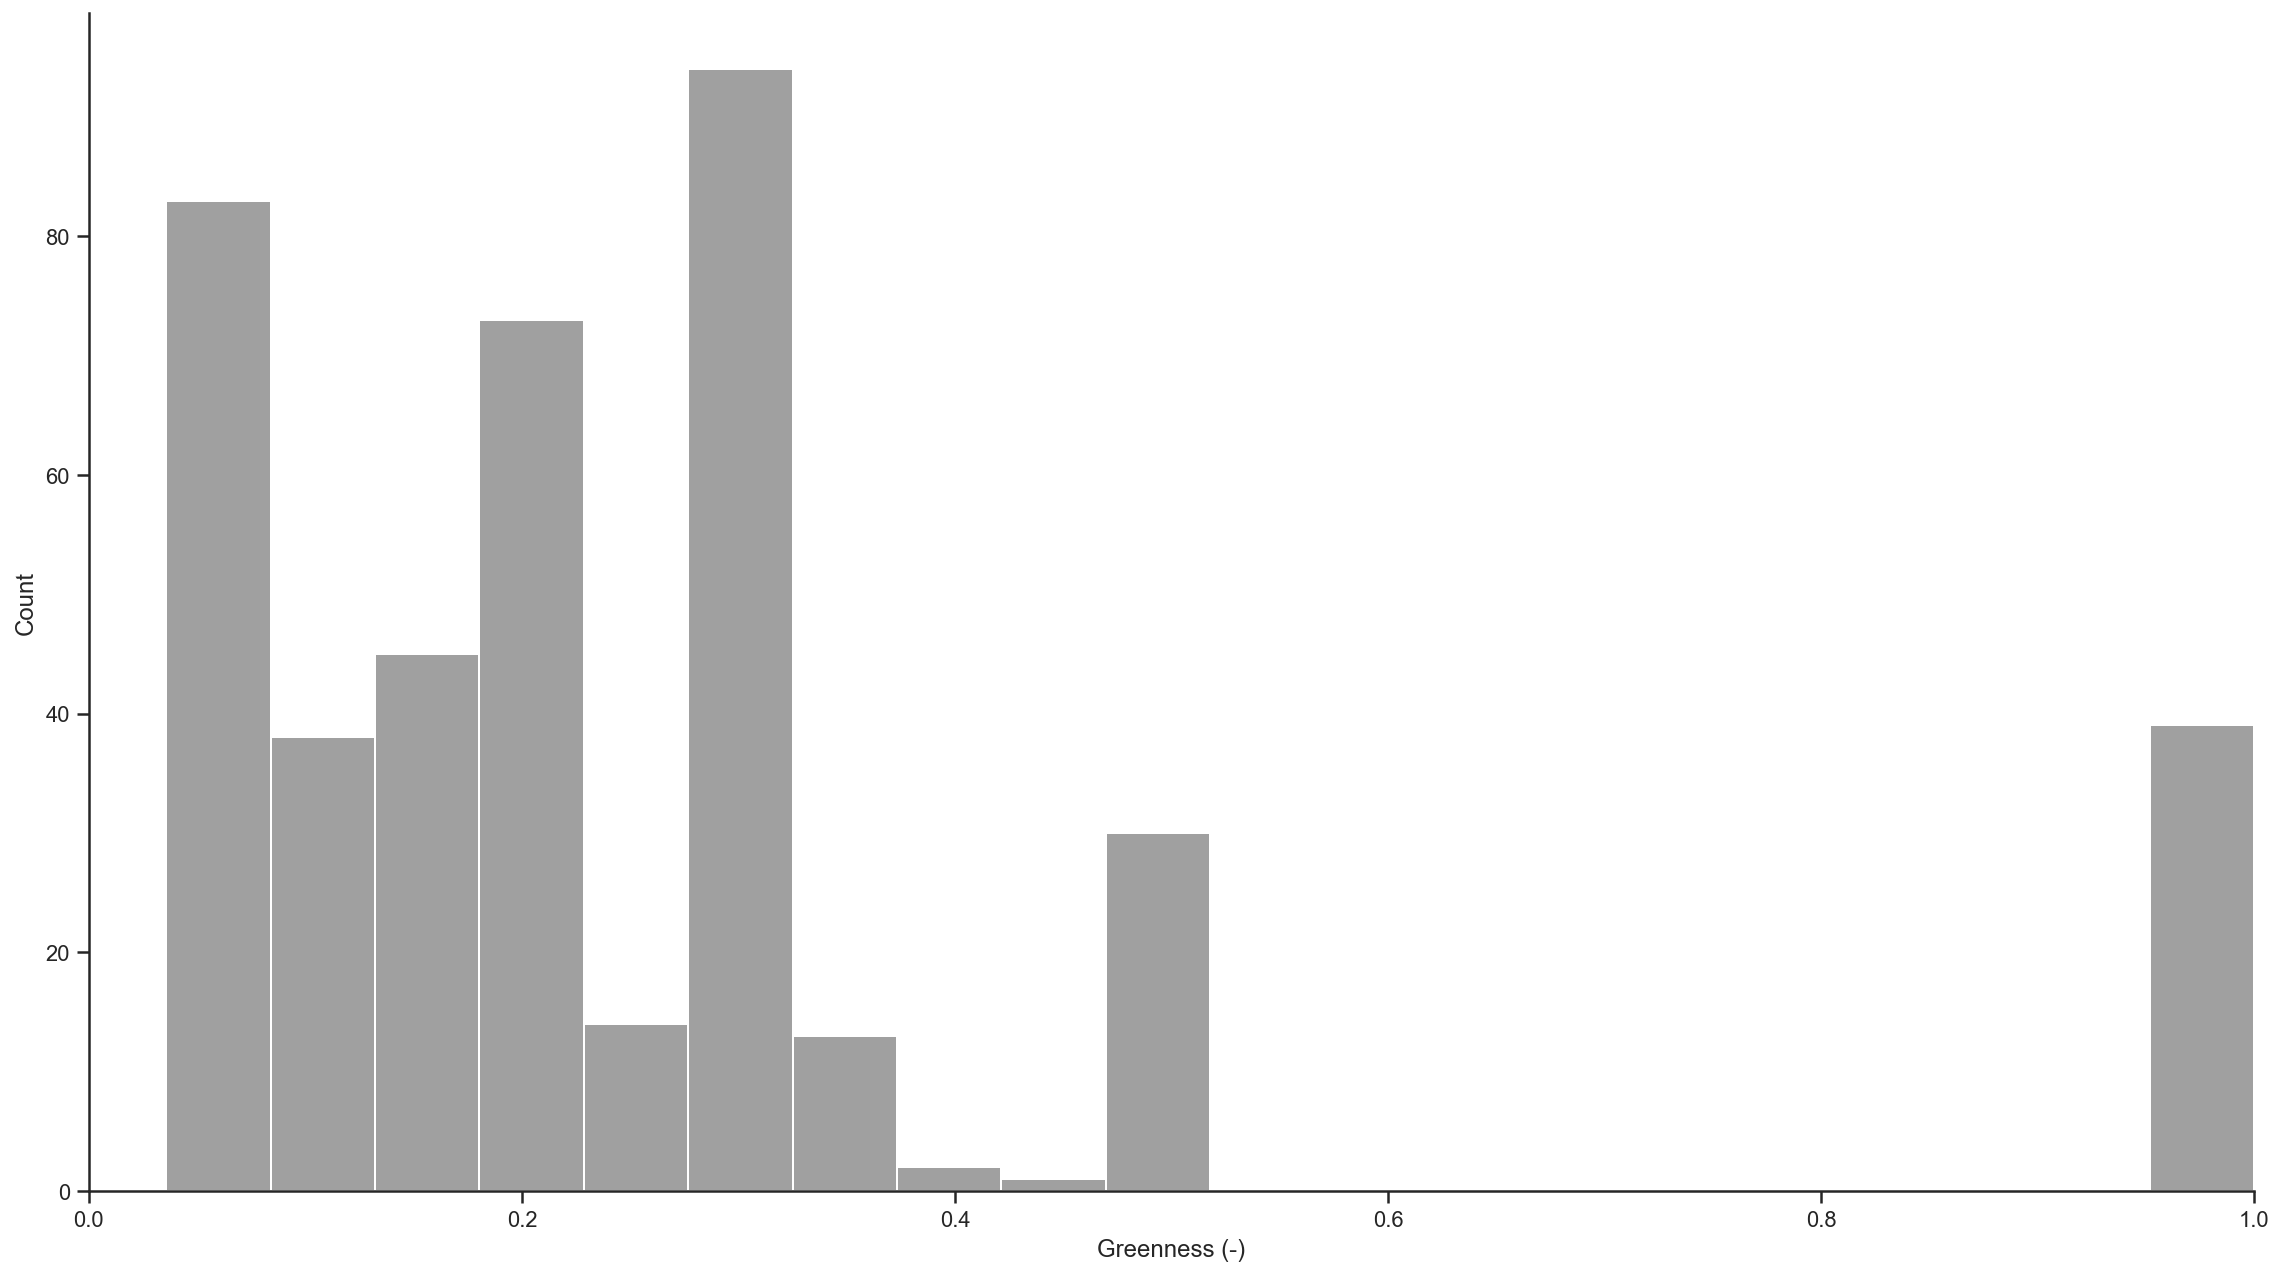

In [116]:
greenness = df_metadata.greenness_vona_2018_v2
greenness = greenness.replace(0, np.nan)
ax = sns.histplot(
    greenness,
    stat="count",
    color="grey",
    bins=20,
)

ax.set_xlim(0, 1)
ax.set_xlabel("Greenness (-)")

sns.despine()
plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "RQ2", "greenness_v2_histogram.png"),
    dpi=150,
    bbox_inches="tight"
)

In [82]:
occ_skills_matrix = pd.read_pickle(
        os.path.join(project_dir, "data", "processed", "adjacency_matrix.pkl")
)

occ_skills_matrix_eo = pd.read_pickle(
        os.path.join(project_dir, "data", "processed", "adjacency_matrix_essential_optional.pkl")
)

In [124]:
# remove military occupations
df_cond = pd.read_csv(os.path.join(data_interim, "esco_military_occupations.csv"), index_col=0)
non_military_indices = df_cond[~df_cond.military].index.values

occ_skills_matrix = occ_skills_matrix.iloc[non_military_indices, :]
occ_skills_matrix_eo = occ_skills_matrix_eo.iloc[non_military_indices, :]

In [125]:
occ_skills_matrix_sub = occ_skills_matrix.iloc[df_subset.concept_uri.index.values,:]

In [126]:
skills["n_greenness_1"] = occ_skills_matrix_sub.sum(axis=0).values

In [127]:
skills_sub = skills[skills.n_greenness_1 > 1].sort_values("n_greenness_1", ascending=False)

### Prepare tables for thesis

In [128]:
skill_cols = ["preferredLabel", "reuseLevel", "n_greenness_1"]
skills_sub[skill_cols].head(30).reset_index(drop=True).to_csv(
    os.path.join(data_processed, "greenness_skills.csv")
)

In [129]:
occ_cols = ["preferred_label", "occupation_type", "greenness_vona_2018_v2"]
df_subset[occ_cols].reset_index(drop=True).to_csv(
    os.path.join(data_processed, "greenness_occupations.csv")
)

### Analysis 2
- replicate analysis 1 while differentiating between essential and optional skills

In [130]:
# occ_skills_matrix_eo_sub = occ_skills_matrix_eo.iloc[df_subset.concept_uri.index.values,:]
occ_skills_matrix_e = occ_skills_matrix_eo.replace(to_replace=2, value=0)
occ_skills_matrix_o = occ_skills_matrix_eo.replace(to_replace=1, value=0)
occ_skills_matrix_o = occ_skills_matrix_o.divide(2)

In [131]:
occ_skills_matrix_e_sub = occ_skills_matrix_e.iloc[df_subset.concept_uri.index.values,:]
occ_skills_matrix_o_sub = occ_skills_matrix_o.iloc[df_subset.concept_uri.index.values,:]

In [132]:
skills["n_greenness_1_essential"] = occ_skills_matrix_e_sub.sum(axis=0).values
skills["n_greenness_1_optional"] = occ_skills_matrix_o_sub.sum(axis=0).values

In [133]:
skills.sort_values("n_greenness_1_optional", ascending=False)

,conceptType,conceptUri,skillType,reuseLevel,preferredLabel,altLabels,hiddenLabels,status,modifiedDate,scopeNote,definition,inScheme,description,n_greenness_1,n_greenness_1_essential,n_greenness_1_optional,n_greenness_weighted
6292,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/75f312e1-622b...,knowledge,cross-sector,pollution prevention,regulations for pollution prevention\nInternat...,NaN,released,2017-01-05T16:50:21Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,The processes used to prevent pollution: preca...,13,3,10.0,16.22
7384,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/8abdc43c-2bfd...,skill/competence,cross-sector,promote environmental awareness,promoting environmental awareness\nendorse env...,NaN,released,2017-02-10T17:31:05Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,Calculate the carbon footprint of business pro...,16,6,10.0,18.31
5184,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/6122d586-5978...,skill/competence,cross-sector,wear appropriate protective gear,clothe in appropriate protective gear\nput on ...,NaN,released,2016-12-20T19:52:20Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,"Wear relevant and necessary protective gear, s...",12,2,10.0,17.60
3455,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/40fa39b5-0f69...,skill/competence,cross-sector,dispose of hazardous waste,eliminate dangerous waste\nremove hazardous wa...,NaN,released,2016-12-20T19:49:43Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,Dispose of dangerous materials such as chemica...,8,0,8.0,8.99
11672,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/de131ede-cbfe...,skill/competence,sector-specific,report pollution incidents,report incidents of pollution\nreporting pollu...,NaN,released,2016-12-20T17:30:10Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/skil...,"When an incident causes pollution, examine the...",9,1,8.0,9.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4579,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/55d42108-1d7e...,knowledge,occupation-specific,screw manufacturing processes,screw manufacturing processes\nscrew manufactu...,NaN,released,2017-01-06T11:15:40Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/skil...,The various manufacturing processes performed ...,0,0,0.0,0.00
4580,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/55d46c76-385c...,skill/competence,sector-specific,analyse apple juice for cider production,test apple juice for cider production\nsearch ...,NaN,released,2017-01-05T09:55:21Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,Analyse apple juice before fermentation and th...,0,0,0.0,0.10
4581,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/55dda75d-698c...,skill/competence,sector-specific,protect health and safety when handling animals,ensure health and safety when handling animals...,NaN,released,2016-12-20T21:19:08Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/skil...,Protect health and welfare of animals and thei...,0,0,0.0,0.00
4582,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/55e286cf-b8a0...,knowledge,sector-specific,types of aircraft,brands of aircraft\nvarieties of aircraft\ntyp...,NaN,released,2016-12-20T20:45:07Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/skil...,"The various types of aircraft, their functiona...",0,0,0.0,1.01


In [134]:
pd.set_option('precision', 2)
skills.loc[:, skills.columns.str.startswith("n_")].corr(method="spearman")

,n_greenness_1,n_greenness_1_essential,n_greenness_1_optional,n_greenness_weighted
n_greenness_1,1.00,0.75,0.84,0.42
n_greenness_1_essential,0.75,1.00,0.43,0.32
n_greenness_1_optional,0.84,0.43,1.00,0.36
n_greenness_weighted,0.42,0.32,0.36,1.00


### Analysis 3
- count the number of times a skill is required (essential/optional) across all occupations
- multiply this number by the greenness of the occupation

In [135]:
df_subset_2 = df_metadata[df_metadata.greenness_vona_2018_v2 > 0.4]
occ_skills_matrix_sub_2 = occ_skills_matrix.iloc[df_subset_2.concept_uri.index.values,:]

In [136]:
s = df_metadata.greenness_vona_2018_v2.fillna(0)
occ_skills_matrix_weighted = occ_skills_matrix.apply(lambda x: np.asarray(x) * np.asarray(s), axis=0)

In [137]:
skills["n_greenness_weighted"] = occ_skills_matrix_weighted.sum(axis=0).values

In [139]:
skills.sort_values("n_greenness_weighted", ascending=False).head(30)

,conceptType,conceptUri,skillType,reuseLevel,preferredLabel,altLabels,hiddenLabels,status,modifiedDate,scopeNote,definition,inScheme,description,n_greenness_1,n_greenness_1_essential,n_greenness_1_optional,n_greenness_weighted
4223,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/4fabca9a-7435...,skill/competence,cross-sector,perform scientific research,performing scientific research\nengage in scie...,NaN,released,2016-12-20T20:21:53Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,"Gain, correct or improve knowledge about pheno...",12,10,2.0,34.00
1705,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/209a5498-3449...,knowledge,cross-sector,engineering principles,engineering research principles\nengineering w...,NaN,released,2017-01-04T15:30:28Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,"The engineering elements like functionality, r...",10,9,1.0,32.83
4478,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/541561bc-510c...,skill/competence,cross-sector,use technical drawing software,design with specialist software\ndesign using ...,NaN,released,2016-12-20T19:55:25Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/skil...,Create technical designs and technical drawing...,12,11,1.0,29.58
6117,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/72a74f69-5cf1...,knowledge,sector-specific,engineering processes,NaN,NaN,released,2016-09-02T10:02:19Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,The systematic approach to the development and...,11,11,0.0,27.86
3535,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/42b23922-1c40...,skill/competence,cross-sector,adjust engineering designs,adjust manufacturing designs\nadjust construct...,NaN,released,2016-12-20T20:04:35Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/skil...,Adjust designs of products or parts of product...,11,11,0.0,27.78
4781,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/59ea80e1-463a...,knowledge,cross-sector,technical drawings,mechanical drawings\nspecialised drawings\ntec...,NaN,released,2016-12-20T19:12:04Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/skil...,"Drawing software and the various symbols, pers...",11,11,0.0,26.39
12896,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/f54c10e4-630d...,skill/competence,cross-sector,approve engineering design,produce engineering design\ndevelop engineerin...,NaN,released,2016-12-20T20:52:02Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/skil...,Give consent to the finished engineering desig...,10,10,0.0,23.82
2756,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/334e3e49-fb02...,skill/competence,cross-sector,troubleshoot,troubleshooting\nidentify problems\ntroublesho...,NaN,released,2016-12-20T19:57:59Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,"Identify operating problems, decide what to do...",10,7,3.0,20.96
11596,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/dc72ad0a-c5dc...,skill/competence,cross-sector,build business relationships,devise business relationships\nconstruct busin...,NaN,released,2016-12-20T20:50:10Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/skil...,"Establish a positive, long-term relationship b...",1,1,0.0,20.64
424,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/089ee650-297e...,skill/competence,cross-sector,ensure compliance with environmental legislation,lead implementation of environmental policies ...,NaN,released,2017-02-10T18:22:50Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,Monitor activities and perform tasks ensuring ...,12,7,5.0,20.27


In [140]:
df_metadata[df_metadata.greenness_vona_2018_v2 > 0].shape

(432, 37)

In [100]:
skill_cols = ["preferredLabel", "reuseLevel", "n_greenness_1_essential"]
skills[skill_cols].sort_values("n_greenness_1_essential", ascending=False).head(30).reset_index(drop=True).to_csv(
    os.path.join(data_processed, "greenness_skills_essential.csv")
)

skill_cols = ["preferredLabel", "reuseLevel", "n_greenness_1_optional"]
skills[skill_cols].sort_values("n_greenness_1_optional", ascending=False).head(30).reset_index(drop=True).to_csv(
    os.path.join(data_processed, "greenness_skills_optional.csv")
)

skill_cols = ["preferredLabel", "reuseLevel", "n_greenness_1"]
skills[skill_cols].sort_values("n_greenness_1", ascending=False).head(30).reset_index(drop=True).to_csv(
    os.path.join(data_processed, "greenness_skills_all.csv")
)

pd.set_option('precision', 2)
skill_cols = ["preferredLabel", "reuseLevel", "n_greenness_weighted"]
skills[skill_cols].sort_values("n_greenness_weighted", ascending=False).head(30).reset_index(drop=True).to_csv(
    os.path.join(data_processed, "greenness_skills_weighted.csv"),
    float_format='%.2f'
)